# Tutorial Variational Trajectory Planning: Build your first motion planner

This tutorial shows how you can plan trajectories by solving an optimization problem. We therefore use the CommonRoad scenario 'ZAM_Tutorial-1_2_T-1.xml'. 

## Task of the Ego Vehicle

The ego vehicle has the following specification in our scenario:
- obstacle type: car
- obstacle shape: rectangle with a width of 1.844m and a length of 4.569m as presribed in <a href="https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/blob/master/Python/parameters_vehicle3.py">VW Vanagon, Vehicle Type 3</a>
- initial state:
    - position: (15, 0.0) m
    - orientation: 0.00 rad
    - velocity: 22 m/s
- ID in ZAM_Tutorial-1_2_T-1.xml: 100

The following physical constraints apply to the ego vehicle:
- minimum acceleration: -6 m/s2
- maximum acceleration: 15 m/s2
- minimum jerk: -15 m/s3
- maximum jerk: 15 m/s3

The task of the ego vehicle is to reach its target velocity of 30.0 m/s without colliding with other obstacles. 


# Excercise 0: Read the created CommonRoad scenario

The CommonRoadFileReader reads the Scenario and the PlanningProblemSet from a CommonRoad XML-file. Please read the scenario from the CommonRoad file.

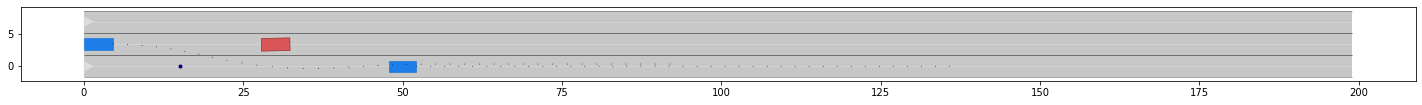

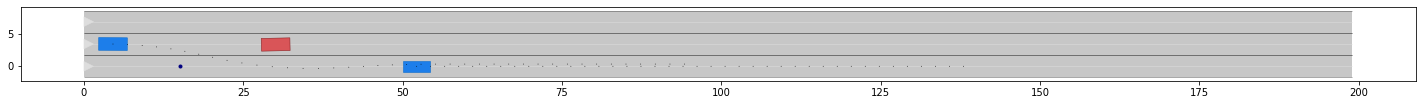

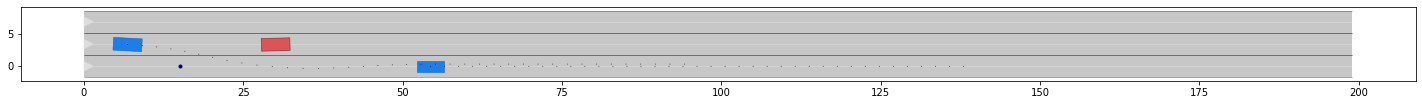

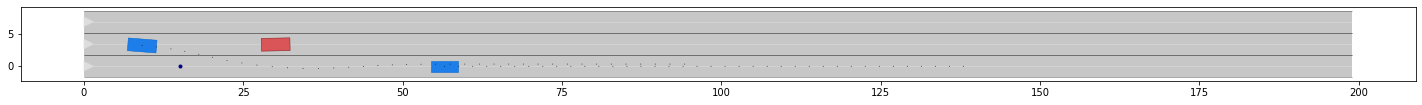

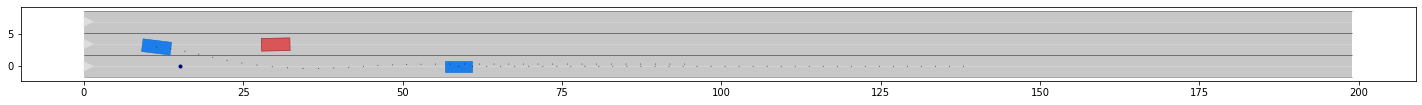

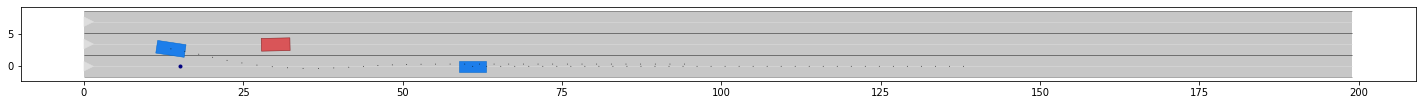

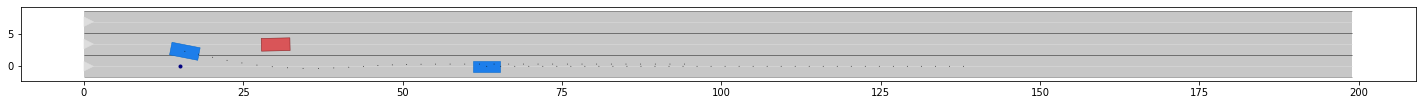

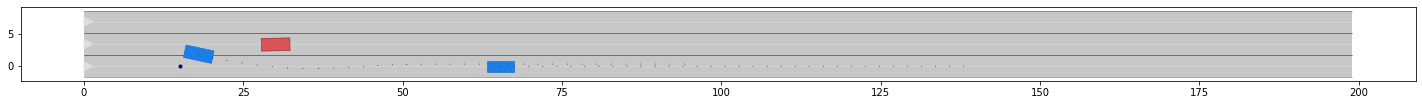

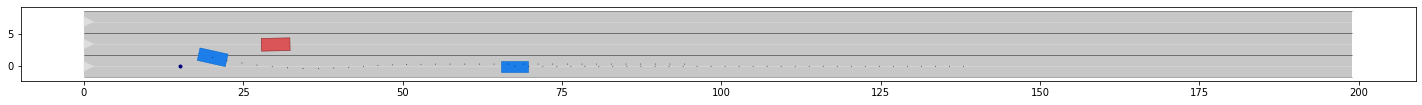

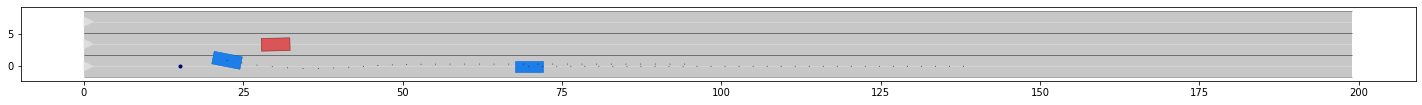

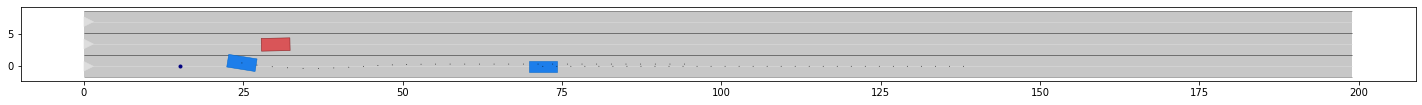

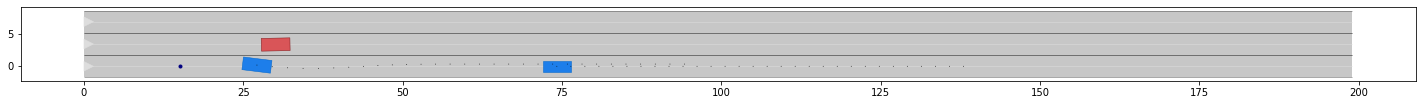

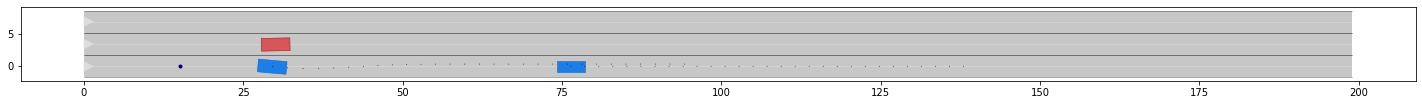

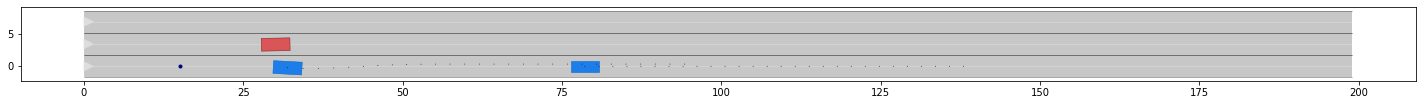

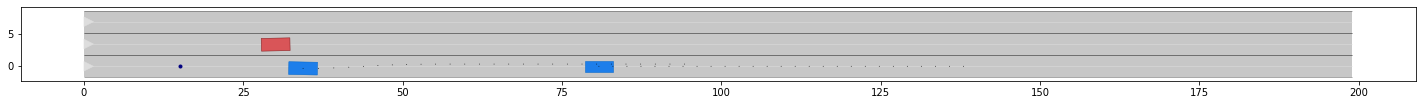

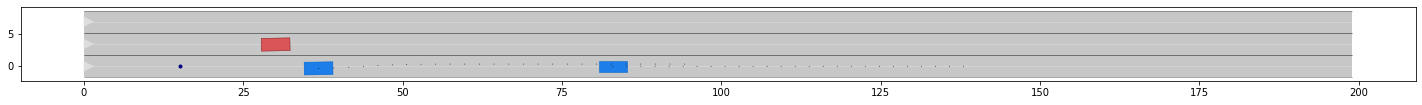

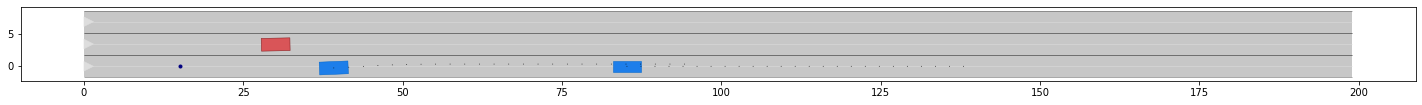

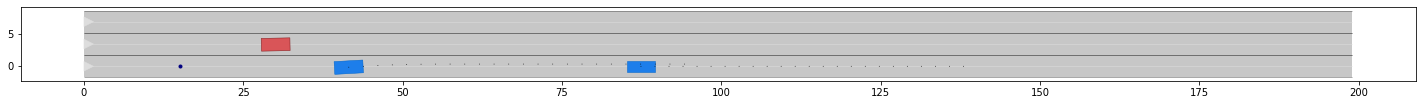

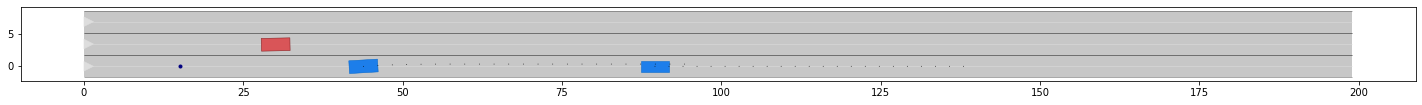

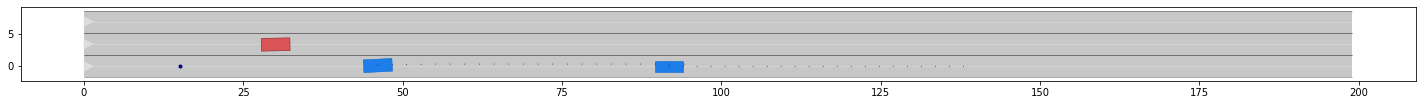

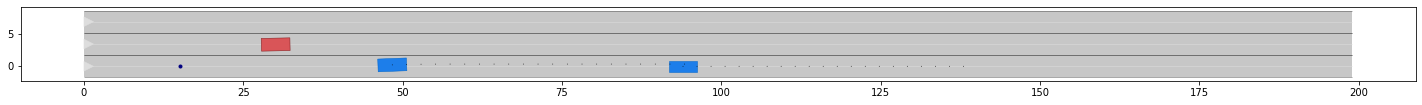

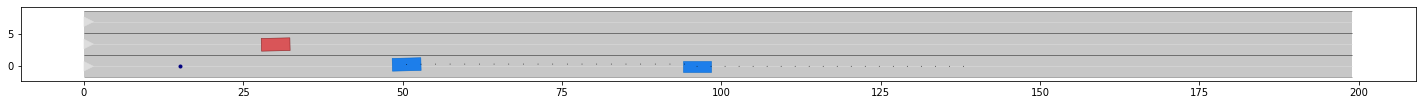

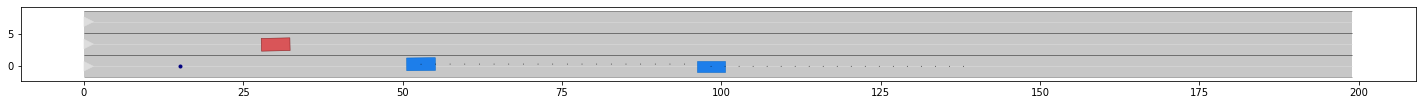

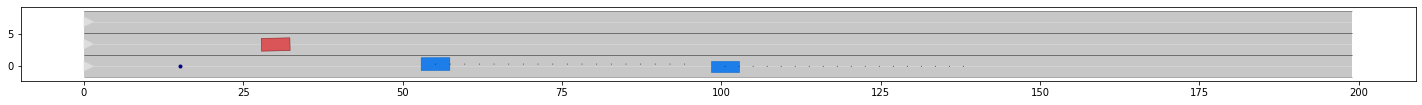

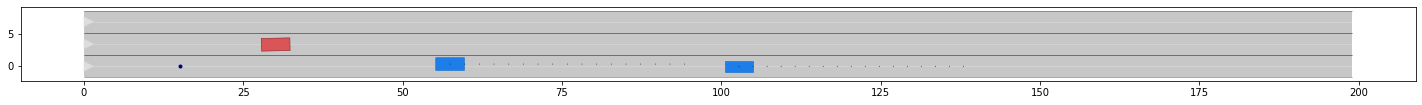

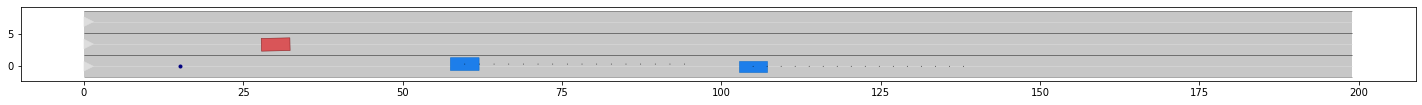

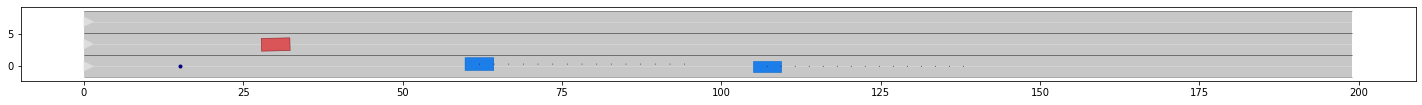

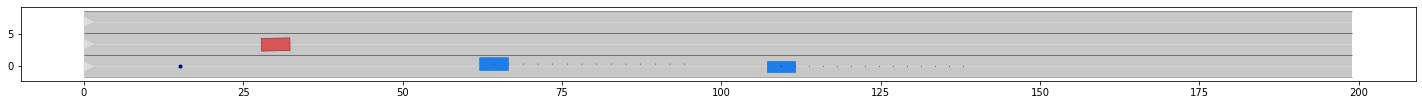

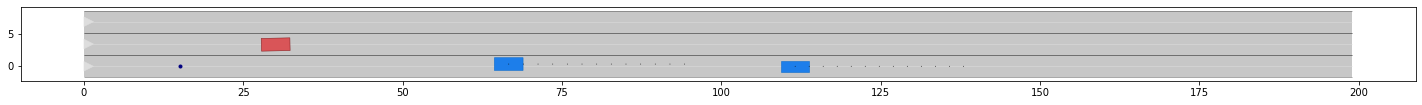

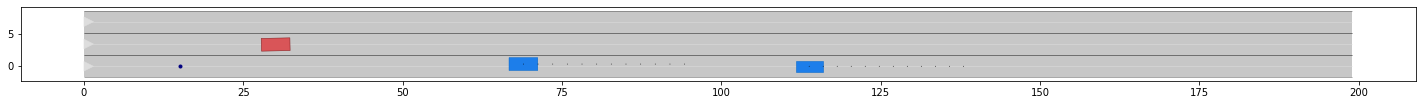

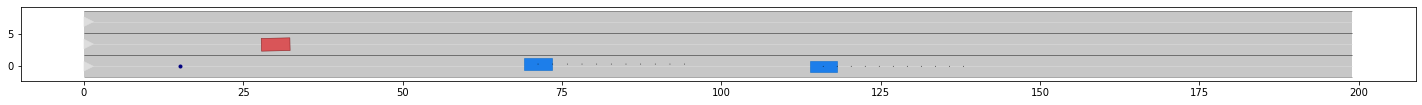

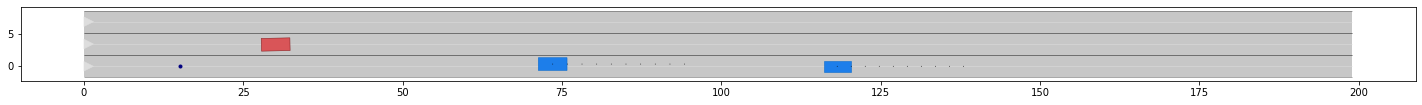

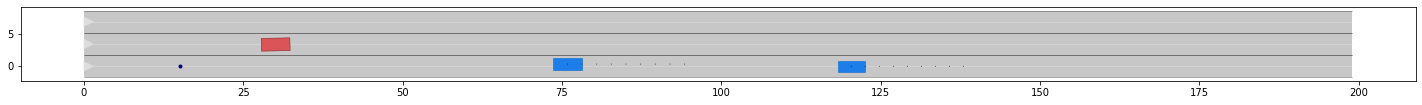

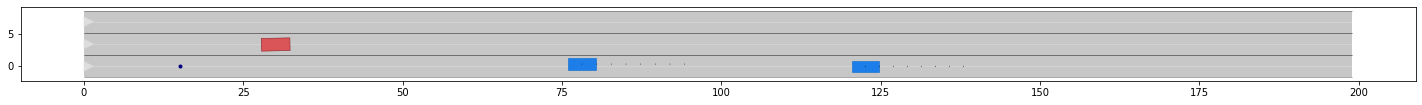

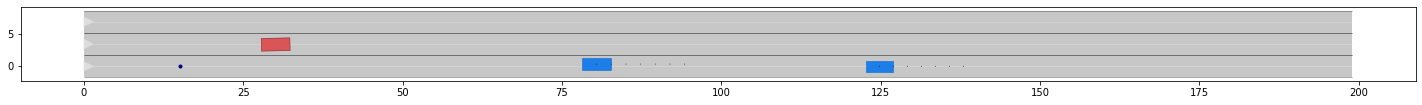

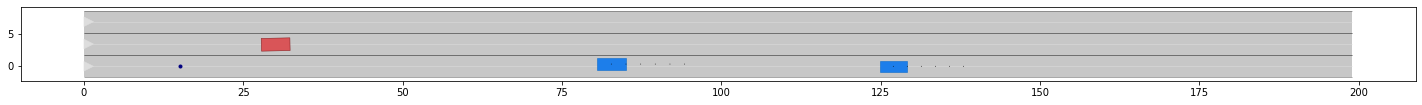

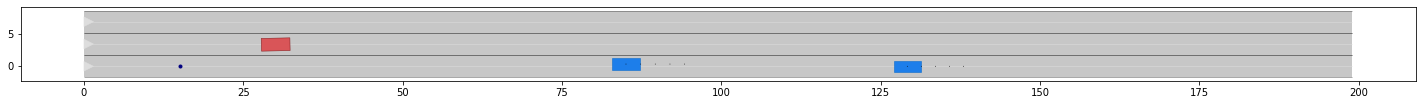

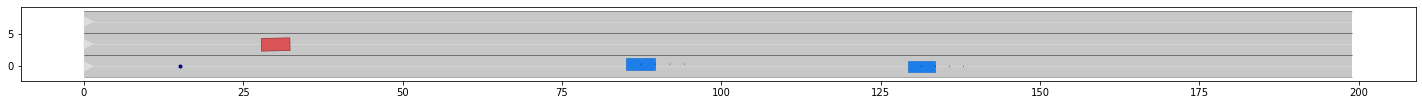

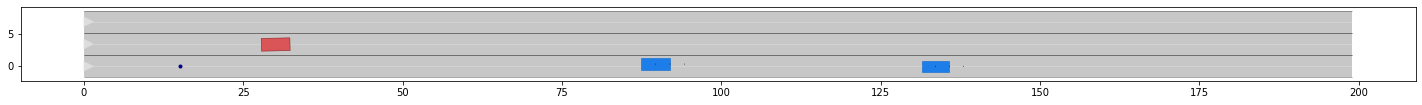

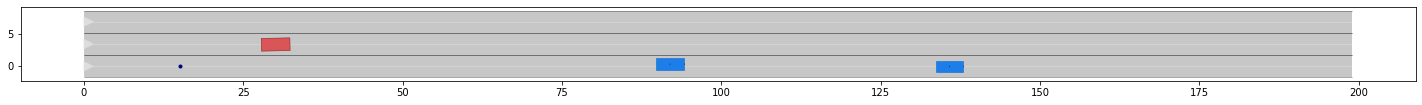

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.draw_dispatch_cr import draw_object

# load the CommonRoad scenario that has been created in the CommonRoad tutorial
file_path = os.path.join(os.getcwd(), 'ZAM_Tutorial-1_2_T-1.xml')

scenario, planning_problem_set = CommonRoadFileReader(file_path).open()

# plot the scenario for each time step
for i in range(0, 40):
    plt.figure(figsize=(25, 10))
    draw_object(scenario, draw_params={'time_begin': i})
    draw_object(planning_problem_set)
    plt.gca().set_aspect('equal')
    plt.show()

# Helper Functions for visualization

The following functions are necessary for this tutorial.

In [4]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    print('Matplotlib not installed. Please use pip(3) to install required package!')

try:
    import numpy as npy
except ImportError:
    print('Numpy not installed. Please use pip(3) to install required package!')
    
try:
    from cvxpy import *
except ImportError:
    print('CVXPy not installed. Please use pip(3) to install required package!')

class TIConstraints:
    a_min = -8
    a_max = 15
    s_min = 0
    s_max = 150
    v_min = 0
    v_max = 35
    j_min = -30
    j_max = 30
    

def plot_state_vector(x : Variable, c : TIConstraints, s_obj = None):
    plt.figure(figsize=(10,10))
    N = x.size[1]-1
    s_max = npy.maximum(150,100+0*npy.ceil(npy.amax(x[0,:].value.A.flatten())*1.1/10)*10)

    # Plot (x_t)_1.
    plt.subplot(4,1,1)
    x1 = x[0,:].value.A.flatten()
    plt.plot(npy.array(range(N+1)),x1,'g')
    if s_obj is not None:
        plt.plot(npy.array(range(1,N+1)),s_obj[0],'b')
        plt.plot(npy.array(range(1,N+1)),s_obj[1],'r')
    plt.ylabel(r"$s$", fontsize=16)
    plt.yticks(npy.linspace(c.s_min, s_max, 3))
    plt.ylim([c.s_min, s_max])
    plt.xticks([])

    # Plot (x_t)_2.
    plt.subplot(4,1,2)
    x2 = x[1,:].value.A.flatten()
    plt.plot(npy.array(range(N+1)),x2,'g')
    plt.yticks(npy.linspace(c.v_min,c.v_max,3))
    plt.ylim([c.v_min, c.v_max+2])
    plt.ylabel(r"$v$", fontsize=16)
    plt.xticks([])

    # Plot (x_t)_3.
    plt.subplot(4,1,3)
    x2 = x[2,:].value.A.flatten()
    plt.plot(npy.array(range(N+1)),x2,'g')
    plt.yticks(npy.linspace(c.a_min,c.a_max,3))
    plt.ylim([c.a_min, c.a_max+2])
    plt.ylabel(r"$a$", fontsize=16)
    plt.xticks([])

    # Plot (x_t)_4.
    plt.subplot(4,1,4)
    x2 = x[3,:].value.A.flatten()
    plt.plot(npy.array(range(N+1)), x2,'g')
    plt.yticks(npy.linspace(c.j_min,c.j_max,3))
    plt.ylim([c.j_min-1, c.j_max+1])
    plt.ylabel(r"$j$", fontsize=16)
    plt.xticks(npy.arange(0,N+1,5))
    plt.xlabel(r"$k$", fontsize=16)
    plt.tight_layout()
    plt.show()

# Variables of the Optimization Problem

We use the convex optimization package cvxpy to formulate our optimization problem. The following code initializes all necessary variables such as the state and input vector as well as the cost matrices. 

In [5]:
# problem data
N  = 40  # number of time steps
n  = 4   # length of state vector 
m  = 1   # length of input vector
dT = scenario.dt # time step


# set up variables
x = Variable(n,N+1) # optimization vector x contains n states per time step 
u = Variable(m,N) # optimization vector u contains 1 state

# set up constraints
c = TIConstraints()
c.a_min = -6 # Minimum feasible acceleration of vehicle
c.a_max = 6 # Maximum feasible acceleration of vehicle
c.s_min = 0 # Minimum allowed position
c.s_max = 100 # Maximum allowed position
c.v_min = 0 # Minimum allowed velocity (no driving backwards!)
c.v_max = 35 # Maximum allowed velocity (speed limit)
c.j_min = -15 # Minimum allowed jerk 
c.j_max = 15 # Maximum allowed jerk

# weights for cost function
w_s = 0
w_v = 8
w_a = 2
w_j = 2
Q = npy.eye(n)*npy.transpose(npy.array([w_s,w_v,w_a,w_j]))
w_u = 1
R = w_u

# Excercise 1: Consider the vehicle model 

In order to obtain kinematically feasible motion plans, the optimization problem needs to respect the constraints of the vehicle model. We use a linear vehicle model, which can be written in the following state-space form: $$x_{k+1} = A x_k + B u_k.$$ Please fill the matrices A and B according to the fourth-order point-mass model, discretized using the time step dT.

In [6]:
A = npy.array([[1,dT,(dT**2)/2,(dT**3)/6],
               [0,1,dT,(dT**2)/2],
               [0,0,1,dT],
               [0,0,0,1]])
B = npy.array([[(dT**4)/24],
               [(dT**3)/6],
               [(dT**2)/2],
               [dT]])

# Formulation of the Optimization Problem

We are now able to formulate the optimization problem. Please set the initial state of the ego vehicle with a velocity of 0 m/s and its reference velocity. Subsequently, we create the cost terms and constraints of the optimization problem.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.968e+01  +1e+04  2e-01  2e-02  1e+00  2e+02    ---    ---    1  1  - |  -  - 
 1  +6.914e+03  +6.955e+03  +1e+04  5e-01  1e-02  7e+01  1e+02  0.3804  7e-01   2  2  2 |  0  0
 2  +9.555e+03  +9.609e+03  +4e+03  2e-01  4e-03  7e+01  5e+01  0.7241  1e-01   2  2  1 |  0  0
 3  +1.256e+04  +1.270e+04  +2e+03  2e-01  4e-03  2e+02  3e+01  0.6829  5e-01   2  2  1 |  0  0
 4  +1.650e+04  +1.667e+04  +1e+03  2e-01  3e-03  2e+02  2e+01  0.6908  3e-01   2  2  2 |  0  0
 5  +1.632e+04  +1.652e+04  +1e+03  1e-01  3e-03  2e+02  1e+01  0.4420  7e-01   3  2  1 |  0  0
 6  +2.051e+04  +2.080e+04  +6e+02  2e-01  3e-03  3e+02  7e+00  0.8469  5e-01   3  1  1 |  0  0
 7  +2.270e+04  +2.300e+04  +4e+02  2e-01  3e-03  3e+02  5e+00  0.5246  4e-01   2  2  1 |  0  0
 8  +2.949e+04  +2.984e+04  +2e+02  1e-01  2e-

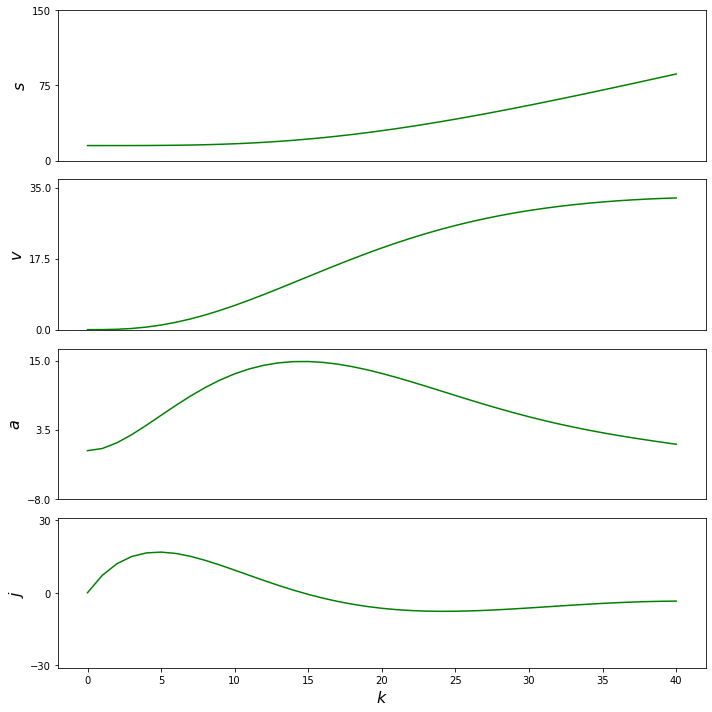

In [7]:
# get the initial state of the ego vehicle from the planning problem set
planning_problem = planning_problem_set.find_planning_problem_by_id(100)
initial_state = planning_problem.initial_state

# initial state of vehicle for the optimization problem (longitudinal position, velocity, acceleration, jerk)
x_0 = npy.array([[initial_state.position[0]],
                 [0],[0],[0]]) # initial state

# reference velocity
v_ref = 30.0
# Set up optimization problem
states = []
for k in range(N):
    # cost function
    cost = quad_form(x[:,k+1]-npy.transpose(npy.array([0,v_ref,0,0])),
                     Q) + quad_form(u[:,k],R)
    # time variant state and input constraints
    constr = [x[:,k+1] == A*x[:,k] + B*u[:,k]]
    states.append( Problem(Minimize(cost), constr) )
    
# sums problem objectives and concatenates constraints.
prob = sum(states)
# initial state and goal state constraints
prob.constraints += [x[:,0] == x_0]

# Solve optimization problem
prob.solve(verbose=True)
print("Problem is convex: ",prob.is_dcp())
print("Problem solution is "+prob.status)

# plot results
plot_state_vector(x, TIConstraints())

# Exercise 2: Consider additional constraints

The obtained trajectory reaches the desired reference velocity of the ego vehicle. However, the physical constraints are not fulfilled. Please add the physical constraints to the optimization problem in order to obtain kinematically feasible trajectories. 

Problem is convex:  True
Problem solution is optimal_inaccurate


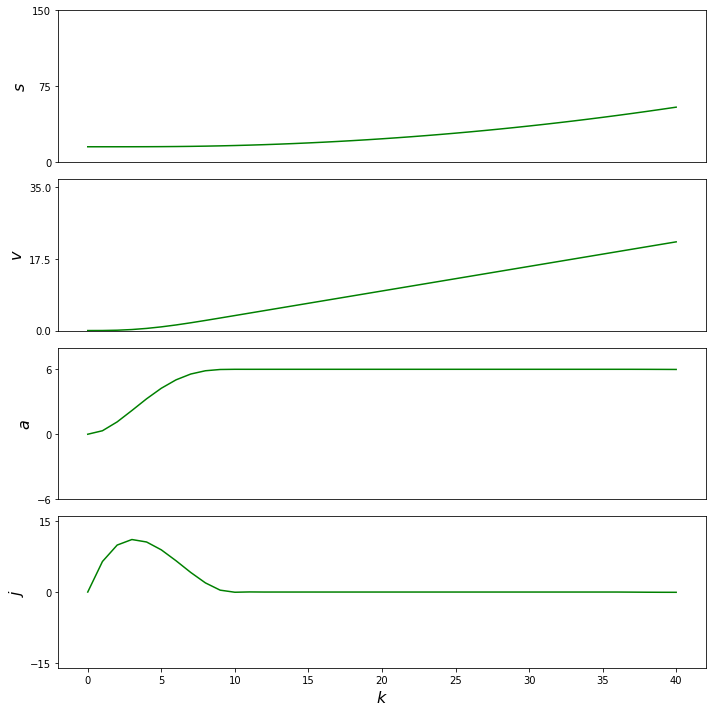

In [8]:
tiConstraints = [x[1,:] <= c.v_max, x[1,:] >= c.v_min] # velocity
tiConstraints += [x[2,:] <= c.a_max, x[2,:] >= c.a_min] # acceleration
tiConstraints += [x[3,:] <= c.j_max, x[3,:] >= c.j_min] # jerk

# Adjust problem
prob.constraints += tiConstraints

# Solve optimization problem
prob.solve()
print("Problem is convex: ",prob.is_dcp())
print("Problem solution is "+prob.status)

# plot results
plot_state_vector(x, c)


# Exercise 3: Extract the prediction of obstacles

In our scenario, the ego vehicle is surrounded by two other traffic participants -- one following and one leading vehicle. In order to not cause a collision with these two vehicles, we need to consider the positions of the two vehicles in our optimization problem. Please obtain the minimum and maximum feasible position of the ego vehicle for each point in time. Please note that each obstacle has a certain shape.   

Following vehicle id=42
Leading vehicle id=44


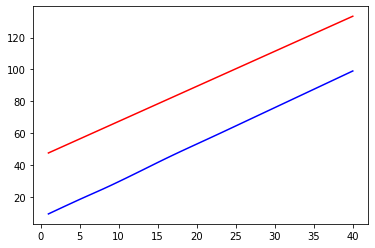

In [9]:
# extract obstacle from scenario
dyn_obstacles = scenario.dynamic_obstacles

# create constraints for minimum and maximum position
s_min = [] # minimum position constraint
s_max = [] # maximum position constraint

# go through obstacle list and distinguish between following and leading vehicle
for o in dyn_obstacles:
    if o.initial_state.position[0] < x_0[0]:
        print('Following vehicle id={}'.format(o.obstacle_id))
        prediction = o.prediction.trajectory.state_list
        for p in prediction:
            s_min.append(p.position[0]+o.obstacle_shape.length/2.+2.5)
    else:
        print('Leading vehicle id={}'.format(o.obstacle_id))
        prediction = o.prediction.trajectory.state_list
        for p in prediction:
            s_max.append(p.position[0]-o.obstacle_shape.length/2.-2.5)
            
# plot vehicle motions
plt.plot(range(1,len(s_min)+1),s_min,'b')
plt.plot(range(1,len(s_max)+1),s_max,'r')

# Exercise 4: Plan the motion of the ego vehicle

The obtained collision constraint allow us to avoid collisions with the following and leading vehicle. Please add the constraints to our optimization problem and obtain a trajectory. 


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -4.896e+03  +2e+04  1e-01  2e-02  1e+00  5e+01    ---    ---    1  1  - |  -  - 
 1  -6.580e+02  -2.056e+03  +6e+03  4e-02  3e-03  1e+01  2e+01  0.8922  2e-01   1  1  1 |  0  0
 2  -3.336e+02  -2.041e+03  +6e+03  6e-02  2e-03  2e+01  1e+01  0.2232  8e-01   2  2  2 |  0  0
 3  +8.191e+02  -8.495e+01  +3e+03  3e-02  9e-04  1e+01  7e+00  0.5753  1e-01   2  2  2 |  0  0
 4  +7.562e+02  -1.510e+02  +3e+03  3e-02  8e-04  1e+01  7e+00  0.4104  7e-01   2  2  1 |  0  0
 5  +9.023e+02  +6.783e+01  +2e+03  3e-02  7e-04  1e+01  6e+00  0.3517  6e-01   2  2  1 |  0  0
 6  +8.604e+02  +6.144e+01  +2e+03  3e-02  7e-04  1e+01  5e+00  0.3327  8e-01   2  2  1 |  0  0
 7  +1.382e+03  +7.226e+02  +2e+03  3e-02  5e-04  1e+01  4e+00  0.3460  2e-01   2  2  2 |  0  0
 8  +1.369e+03  +7.140e+02  +2e+03  3e-02  5e-

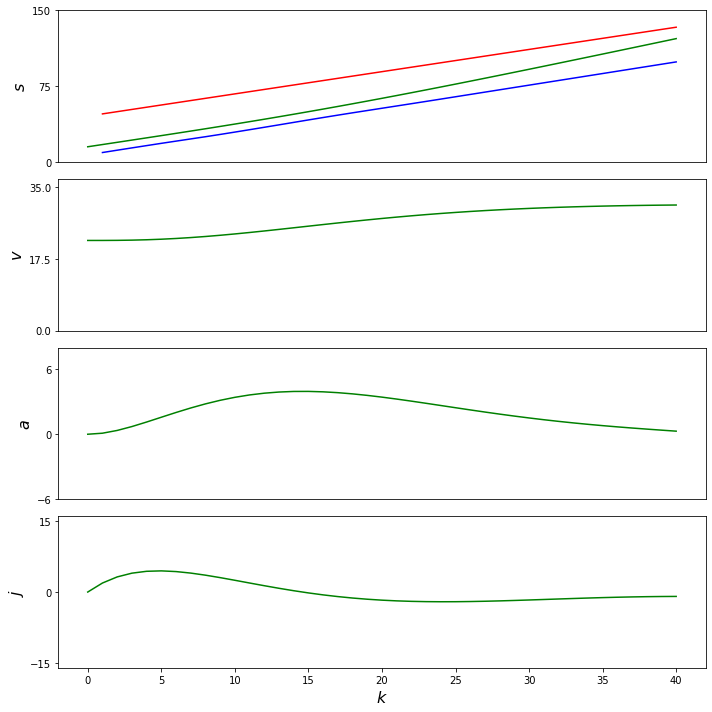

In [10]:
# initial state of ego vehicle
x_0 = npy.array([[initial_state.position[0]],
                 [initial_state.velocity],[0],[0]]) # initial state

# reference velocity
v_ref = 30.0

# Set up optimization problem
states = []
for k in range(N):
    # cost function
    cost = quad_form(x[:,k+1]-npy.transpose(npy.array([0,v_ref,0,0])),Q) + quad_form(u[:,k],R) 
    # single state and input constraints
    constr = [x[:,k+1] == A*x[:,k] + B*u[:,k]]
    # add obstacle constraint
    constr += [x[0,k+1] <= s_max[k]]
    constr += [x[0,k+1] >= s_min[k]]
    states.append( Problem(Minimize(cost), constr) )
    
# sums problem objectives and concatenates constraints.
prob = sum(states)
# constraints for all states and inputs
prob.constraints += tiConstraints
# initial state and goal state constraints
prob.constraints += [x[:,0] == x_0]

# Solve optimization problem
prob.solve(verbose=True)
print("Problem is convex:",prob.is_dcp())
print("Problem solution is "+prob.status)

# plot results
plot_state_vector(x, c, [s_min,s_max])

s_ego = x[0,:].value.A.flatten()
v_ego = x[1,:].value.A.flatten()

# Exercise 5

We have successfully planned the motion of the ego vehicle. Please convert the ego vehicle to a dynamic obstacle and visualize the scenario and the motion of the ego vehicle for each time step. 

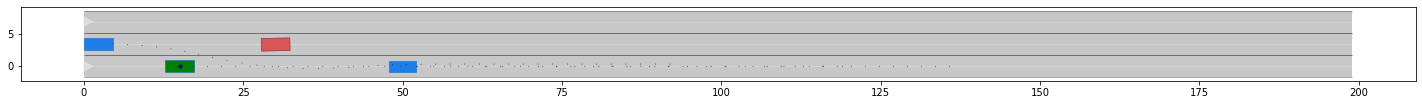

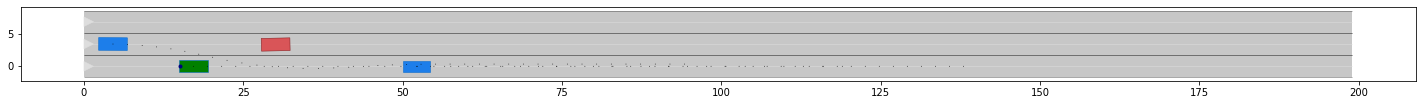

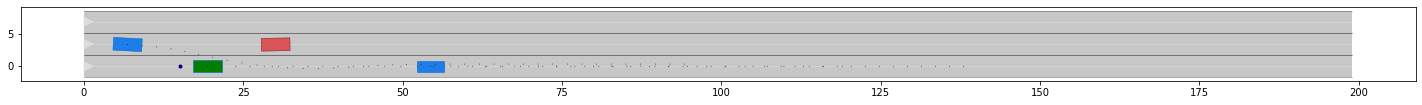

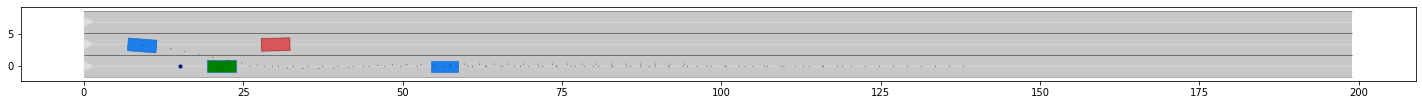

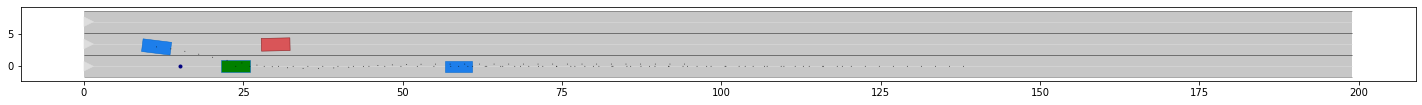

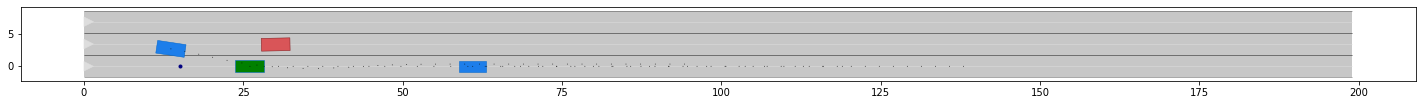

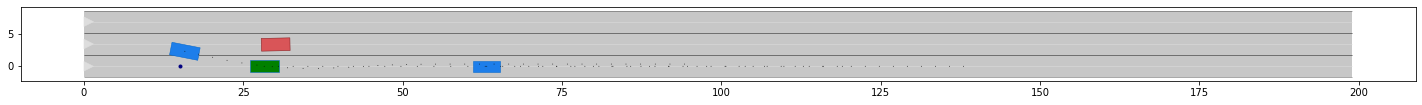

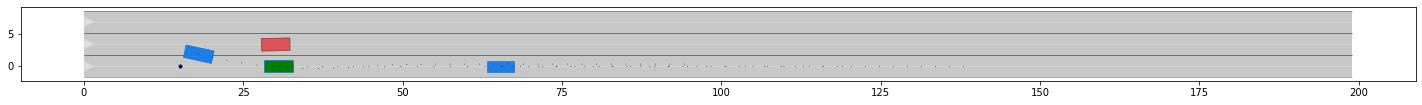

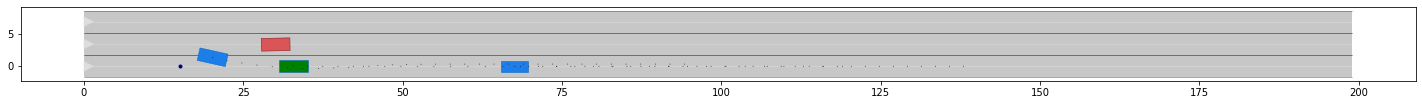

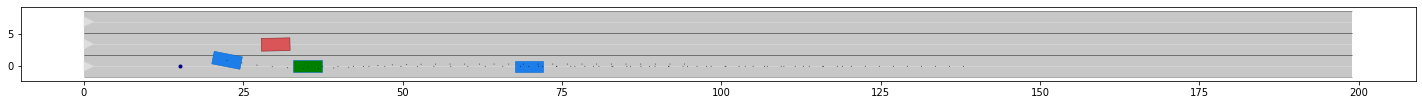

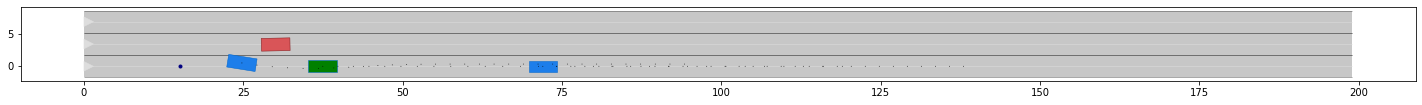

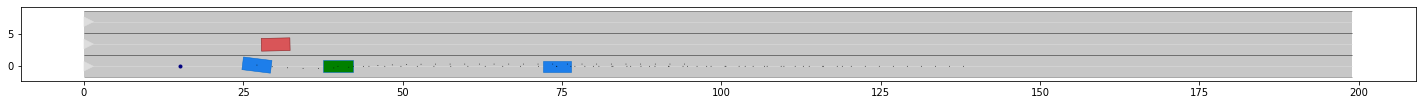

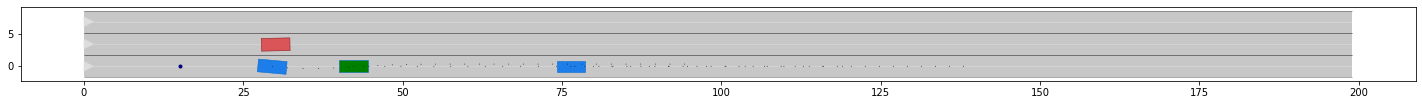

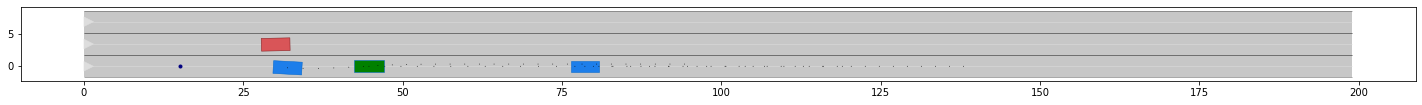

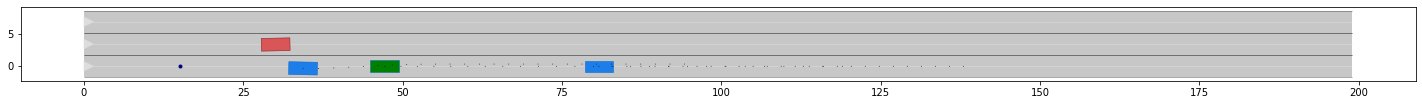

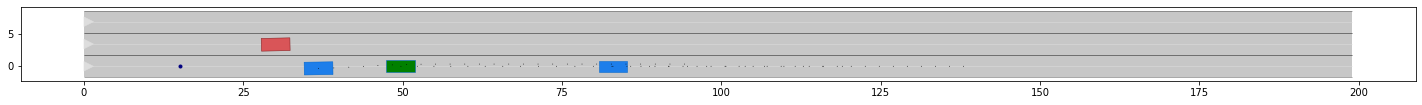

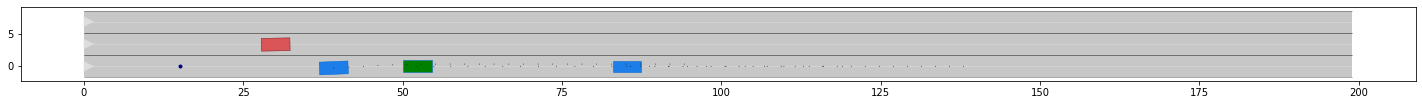

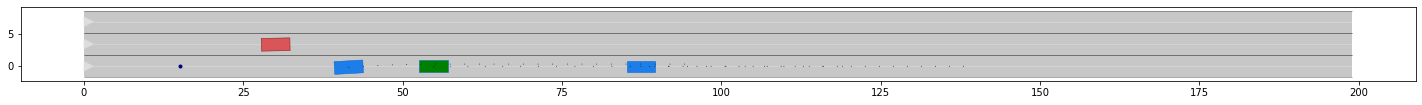

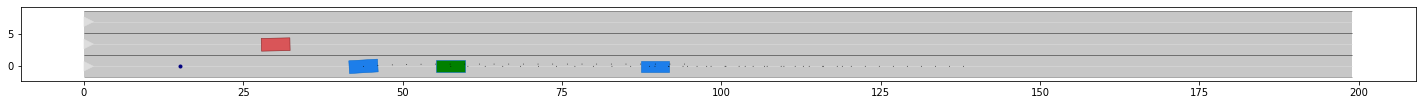

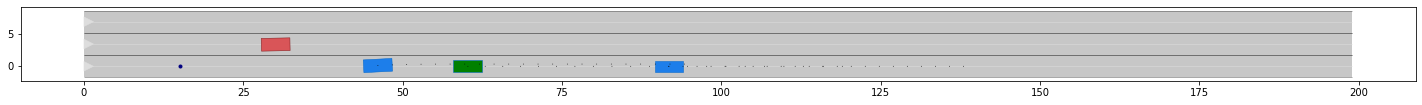

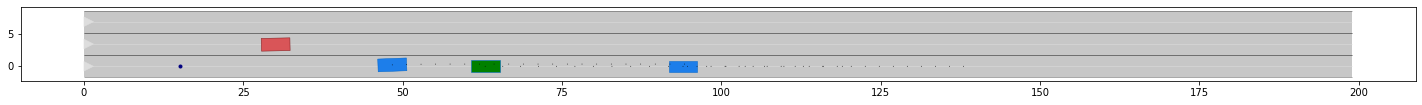

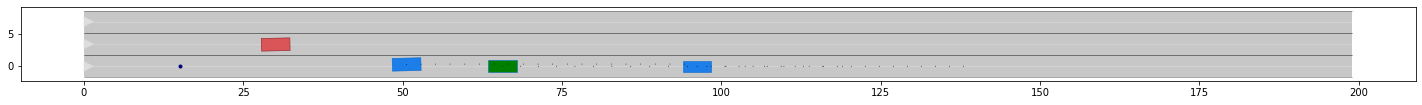

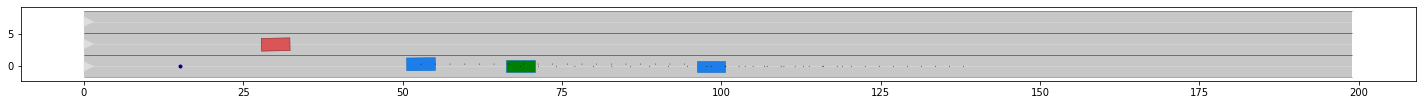

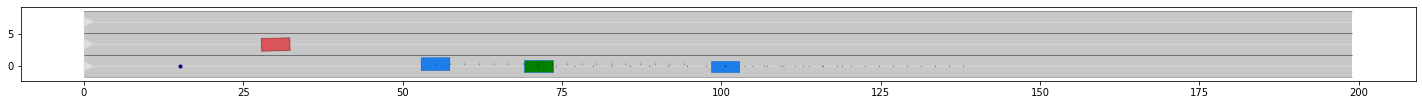

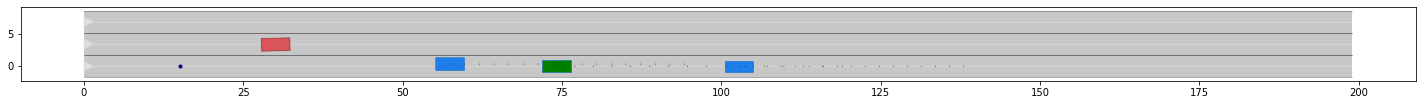

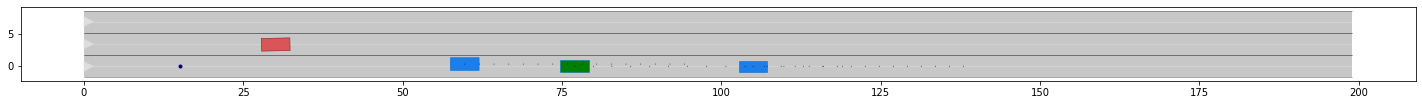

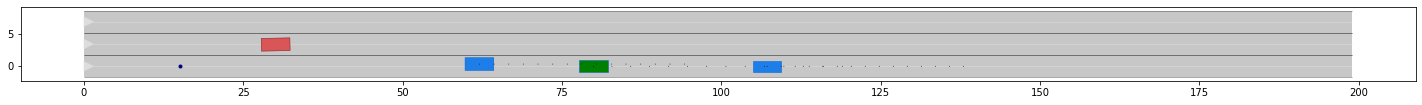

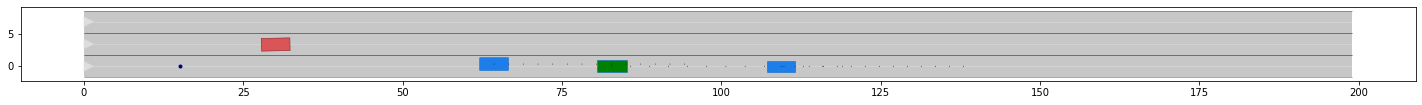

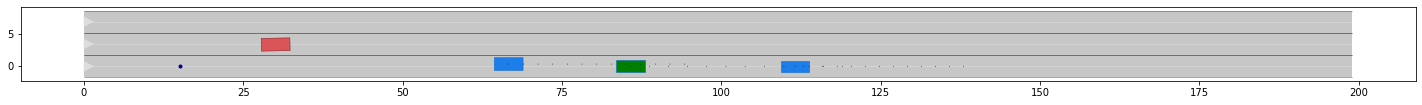

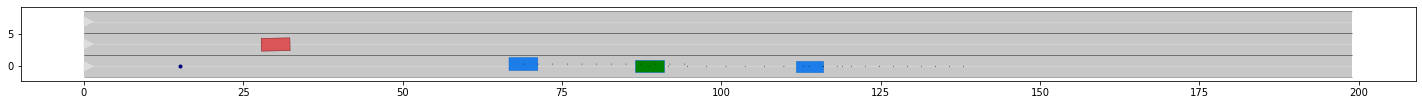

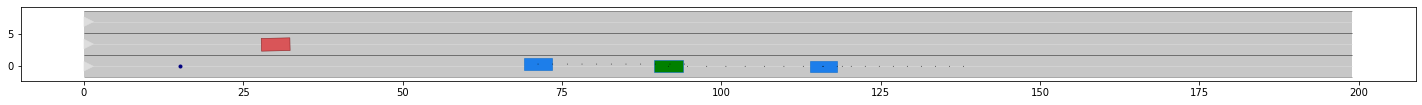

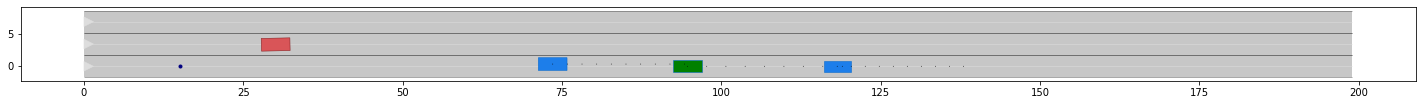

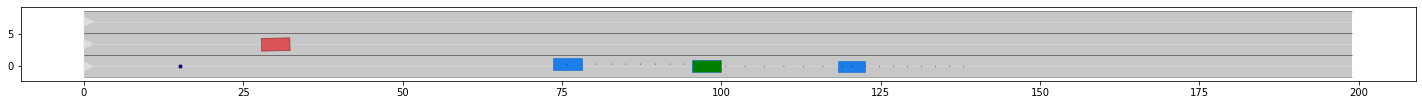

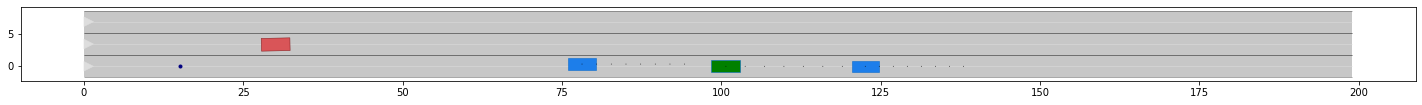

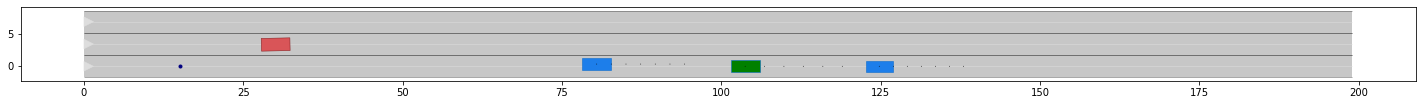

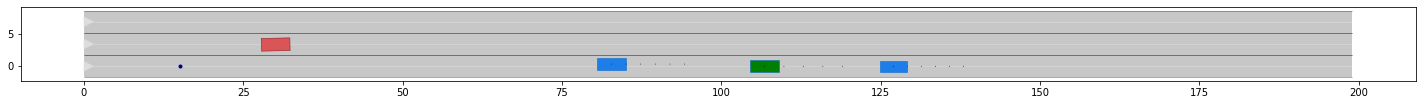

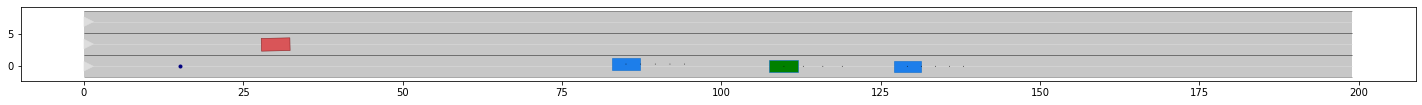

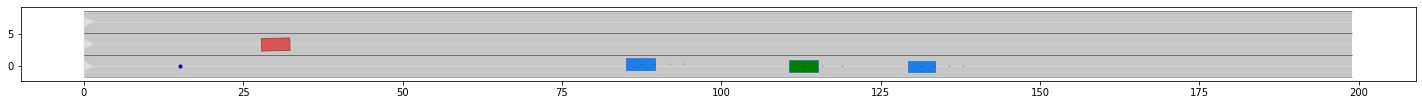

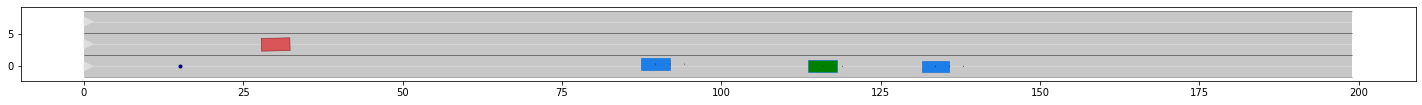

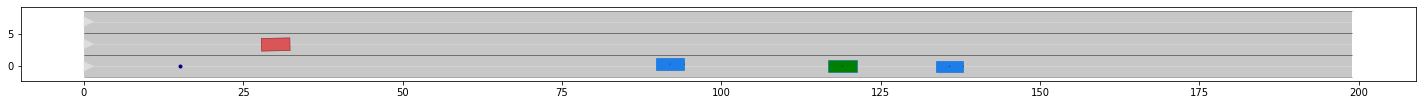

In [12]:
from commonroad.geometry.shape import Rectangle
from commonroad.scenario.obstacle import DynamicObstacle, ObstacleType
from commonroad.scenario.trajectory import Trajectory,State
from commonroad.prediction.prediction import TrajectoryPrediction
import parameters_vehicle3

# generate state list of the ego vehicle's trajectory
state_list = [initial_state]
for i in range(1, N):
    # compute new position
    # add new state to state_list
    orientation = initial_state.orientation
    state_list.append(State(**{'position': npy.array([s_ego[i],0]), 'orientation': orientation,
                               'time_step': i, 'velocity': v_ego[i]*npy.cos(orientation), 
                               'velocity_y': v_ego[i]*npy.sin(orientation)}))
# create the planned trajectory starting at time step 1
ego_vehicle_trajectory = Trajectory(initial_time_step=1, state_list=state_list[1:])
# create the prediction using the planned trajectory and the shape of the ego vehicle

vehicle3 = parameters_vehicle3.parameters_vehicle3()
ego_vehicle_shape = Rectangle(length=vehicle3.l, width=vehicle3.w)
ego_vehicle_prediction = TrajectoryPrediction(trajectory=ego_vehicle_trajectory,
                                              shape=ego_vehicle_shape)

# the ego vehicle can be visualized by converting it into a DynamicObstacle
ego_vehicle_type = ObstacleType.CAR
ego_vehicle = DynamicObstacle(obstacle_id=100, obstacle_type=ego_vehicle_type,
                              obstacle_shape=ego_vehicle_shape, initial_state=initial_state,
                              prediction=ego_vehicle_prediction)

# plot the scenario and the ego vehicle for each time step
for i in range(0, 40):
    plt.figure(figsize=(25, 10))
    draw_object(scenario, draw_params={'time_begin': i})
    draw_object(ego_vehicle, draw_params={'time_begin': i, 'facecolor': 'g'})
    draw_object(planning_problem_set)
    plt.gca().set_aspect('equal')
    plt.show()

# Exercise 6

Now that we have the planned trajectory and motion of our vehicle, we are ready to write the scenario to our solutions file. This can be done by using the Solution Writer provided by Commonroad.

Upon writing to the file, you will find a file named in the following format:

solution_{<a href="https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/blob/master/vehicleModels_commonRoad.pdf">VehicleModel+VehicleType</a>}:{<a href="https://gitlab.lrz.de/tum-cps/commonroad-cost-functions/blob/master/costFunctions_commonRoad.pdf">CostFunction</a>}:{<a href="https://commonroad.in.tum.de/scenarios/">scenario_id</a>}:{ReleaseTag}.xml
    
The above file is ready to be submitted on the submissions page.    

In [ ]:
import os

from commonroad.common.solution_writer import CommonRoadSolutionWriter, VehicleModel, VehicleType, CostFunction
from commonroad.scenario.trajectory import Trajectory, State

# define the object with necessary attributes.
csw = CommonRoadSolutionWriter(output_dir=os.getcwd(), scenario_id='test_scenario', step_size=0.1,
                               vehicle_type=VehicleType.VW_VANAGON, vehicle_model=VehicleModel.PM,
                               cost_function=CostFunction.SA1)

# add trajectory solution
csw.add_solution_trajectory(ego_vehicle_prediction.trajectory, planning_problem_id=5)

csw.write_to_file()

# Exercise 7

To submit the commonroad solution, you need to create a submission <a href="https://commonroad.in.tum.de/submission/create/">here</a>. 

In Create Submission>Browse, upload the file generated in the previous step and submit your solution.